In [1]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import calculate_cov_matrix
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

## Standard Monte Carlo Simluation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-21 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
1008.1504062847832
trading_days_to_simulate: 251
Derivative Price for 2022-08-22 00:00:00
993.3067520890102
RETURNED -1
trading_days_to_simulate: 250
Derivative Price for 2022-08-23 00:00:00
999.1630807259887
RETURNED -1
RETURNED -1
RETURNED -1
trading_days_to_simulate: 249
Derivative Price for 2022-08-24 00:00:00
993.9101555126989
RETURNED -1
RETURNED -1
RETURNED -1
trading_days_to_simulate: 248
Derivative Price for 2022-08-25 00:00:00
1015.9669376152683
trading_days_to_simulate: 247
Derivative Price for 2022-08-26 00:00:00
1004.5048150935238
trading_days_to_simulate: 244
Deri

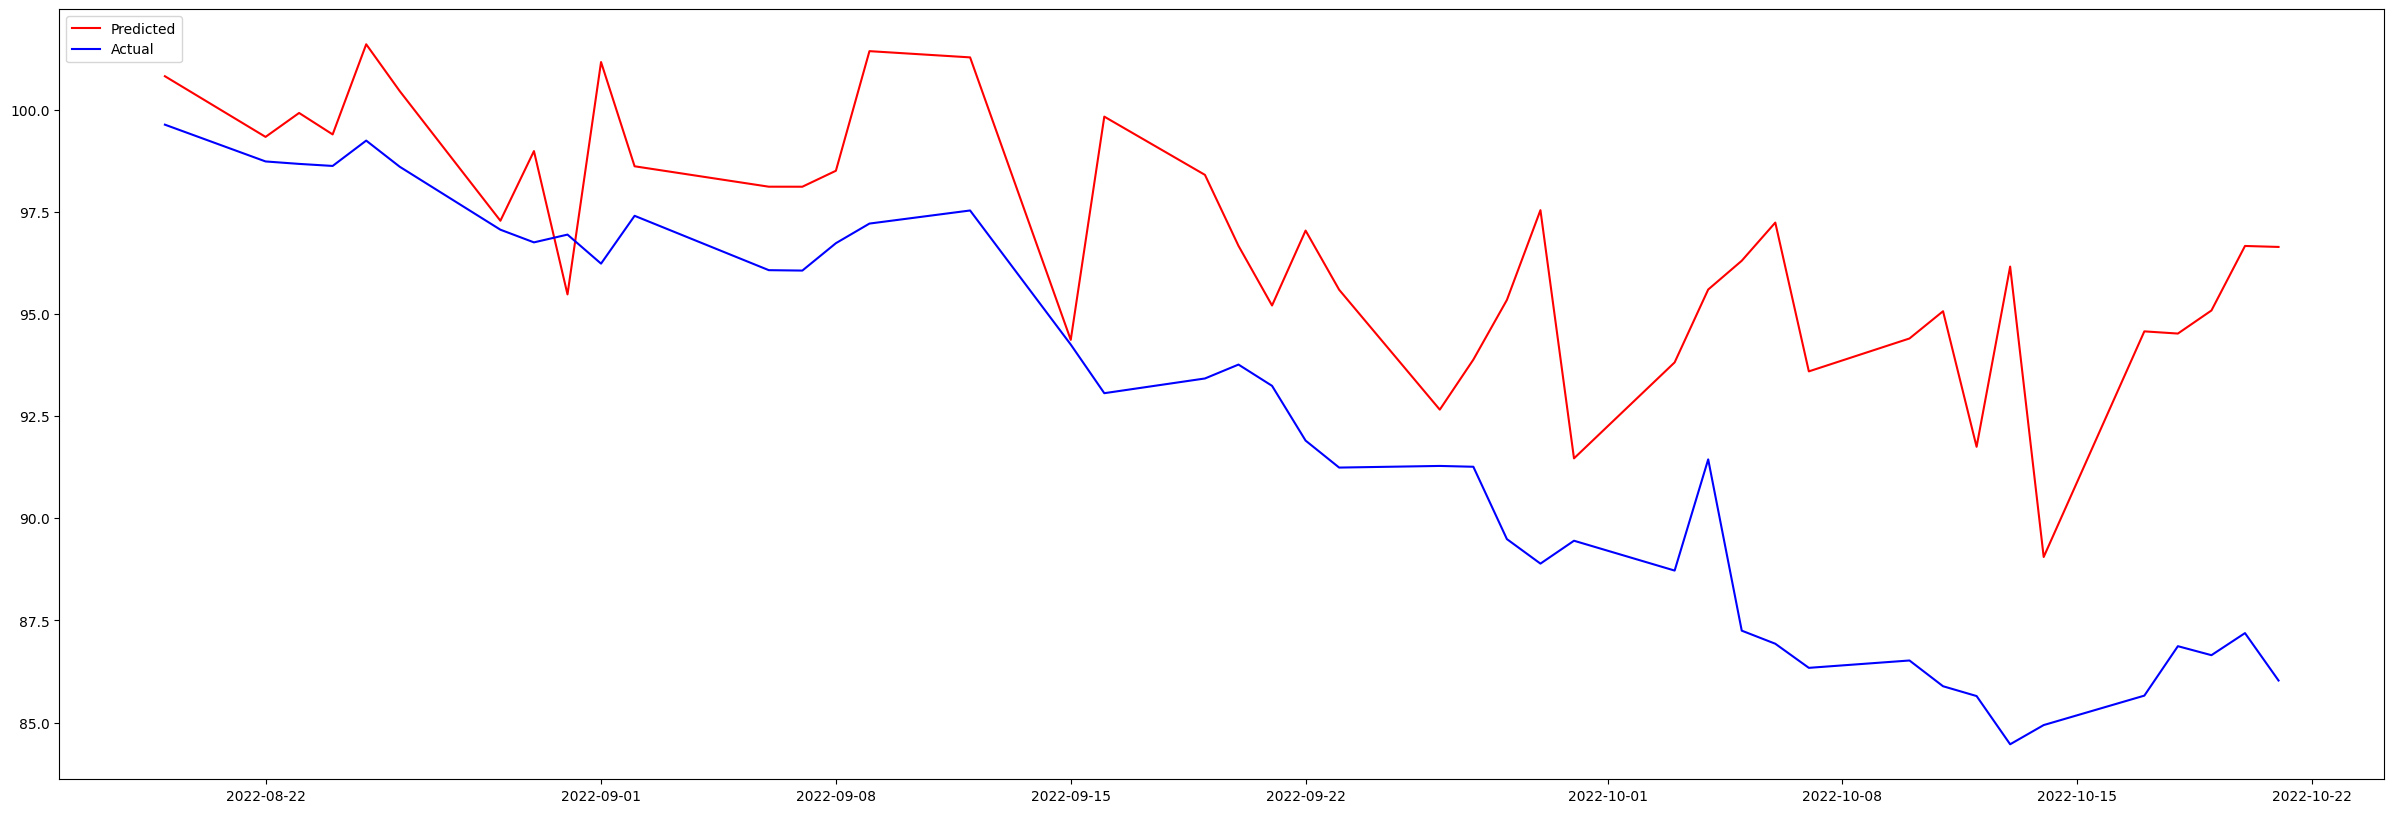

In [14]:
experiment_details = {
    'Nsim': 250,
    'latest_price_date': '2022-10-21',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.045,
    'IV': True,
    'min_sigma':0.0001,
    'max_sigma':5,
    'step':0.00001,
    'error':0.25,
    'EMS': True
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['IV']:

    aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
    aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
    amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
    amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
    googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
    googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    error = experiment_details['error']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

predicted_option_price = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['IV']:
        sigma = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)

## Antithetic Variance Reduction Simulation

In [1]:
experiment_details = {
    'Nsim': 5000,
    'latest_price_date': '2022-10-24',
    'variance_reduction': 'AV',
    'GBM': 'multivariate',
    'r': 0.045
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

# def EMS(SimPaths,Deltat,r):
#     Nsim,m = SimPaths.shape
#     m-=1
#     S = np.zeros((Nsim,m+1))
#     Z = np.zeros((Nsim+1,m))
#     # print(SimPaths[:,0:1])
#     S[:,0:1] = SimPaths[:,0:1]
#     # print(S[:,0:1])


#     for j in range(1,m+1):
#         Z[0:Nsim,j-1:j] = S[:,j-1:j]*SimPaths[:,j:j+1]/SimPaths[:,j-1:j]
#         Z[Nsim:Nsim+1,j-1:j]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[0:Nsim,j-1:j])
#         S[:,j:j+1] = SimPaths[:,0:1]*Z[0:Nsim,j-1:j]/Z[Nsim:Nsim+1,j-1:j]
#     # print(S)
#     return S


date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []
# counter = 0

while date_to_predict <= end_date:
    # if counter == 5:
    #     break

    if date_to_predict in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    dates = AAG['Date']
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    sigma = np.cov(AAGlogreturns, rowvar=False)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']
    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    for i in range(1, int(Nsim/2) + 1):
        S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
        sim_aapl.append(S[0])
        sim_aapl.append(Stilde[0])
        sim_amzn.append(S[1])
        sim_amzn.append(Stilde[1])
        sim_googl.append(S[2])
        sim_googl.append(Stilde[2])

    # sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
    # sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
    # sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    expected_payoff_maturity.append(option_price)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    # cur_expected_payoff = np.mean(payoff_maturity)
    # expected_payoff_maturity.append(cur_expected_payoff)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    # counter+=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)


NameError: name 'days' is not defined

### Control Variate Reduction Simulation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-24 00:00:00
q2_to_maturity: 128
q3_to_maturity: 66
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 255
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 255
Derivative Price for 2022-08-19 00:00:00
965.5054366005944
trading_days_to_simulate: 252
Derivative Price for 2022-08-22 00:00:00
935.9256542369086
trading_days_to_simulate: 251
Derivative Price for 2022-08-23 00:00:00
909.8583577950407
trading_days_to_simulate: 250
Derivative Price for 2022-08-24 00:00:00
917.3460977463233
trading_days_to_simulate: 249
Derivative Price for 2022-08-25 00:00:00
906.8216476641779
trading_days_to_simulate: 248
Derivative Price for 2022-08-26 00:00:00
930.8281106888261
trading_days_to_simulate: 245
Derivative Price for 2022-08-29 00:00:00
869.2640993197128
trading_days_to_simulate: 244
De

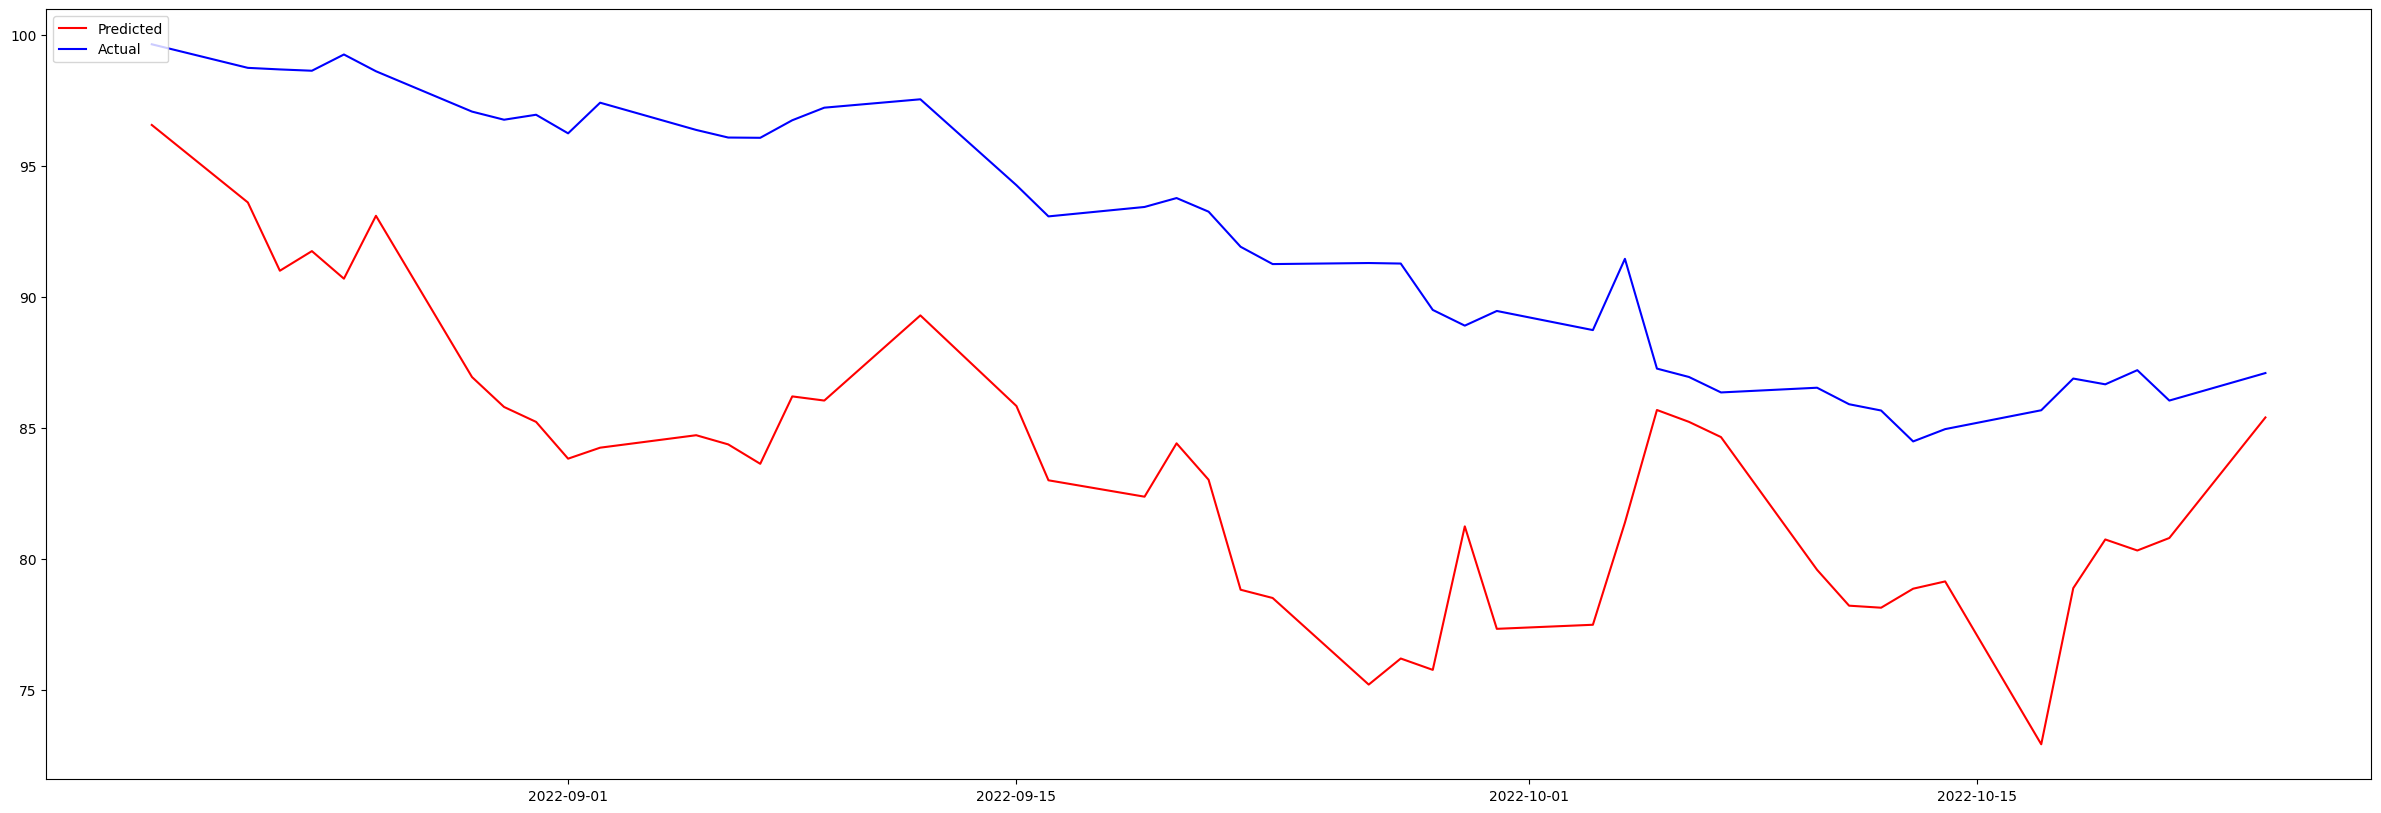

In [2]:
experiment_details = {
    'Nsim': 2500,
    'latest_price_date': '2022-10-24',
    'variance_reduction': 'CV',
    'GBM': 'multivariate',
    'r': 0.045
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

# def EMS(SimPaths,Deltat,r):
#     Nsim,m = SimPaths.shape
#     m-=1
#     S = np.zeros((Nsim,m+1))
#     Z = np.zeros((Nsim+1,m))
#     # print(SimPaths[:,0:1])
#     S[:,0:1] = SimPaths[:,0:1]
#     # print(S[:,0:1])


#     for j in range(1,m+1):
#         Z[0:Nsim,j-1:j] = S[:,j-1:j]*SimPaths[:,j:j+1]/SimPaths[:,j-1:j]
#         Z[Nsim:Nsim+1,j-1:j]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[0:Nsim,j-1:j])
#         S[:,j:j+1] = SimPaths[:,0:1]*Z[0:Nsim,j-1:j]/Z[Nsim:Nsim+1,j-1:j]
#     # print(S)
#     return S


date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []
# counter = 0

while date_to_predict <= end_date:
    # if counter == 5:
    #     break

    if date_to_predict in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    dates = AAG['Date']
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    sigma = np.cov(AAGlogreturns, rowvar=False)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']
    print(f"trading_days_to_simulate: {trading_days_to_simulate}")
    # print(f"m: {m}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    for i in range(1, Nsim + 1):
        S = SimMultiGBMCV(S0, v, sigma, dt, T)
        sim_aapl.append(S[0])
        sim_amzn.append(S[1])
        sim_googl.append(S[2])

    # sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
    # sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
    # sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    expected_payoff_maturity.append(option_price)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    # cur_expected_payoff = np.mean(payoff_maturity)
    # expected_payoff_maturity.append(cur_expected_payoff)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    # counter+=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)

# Estimating Implied Volatility